In [105]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

import datetime
import time

### NHANES - MORT (3.2. Explaining a feature not used by the model)

In [79]:
nhanes = pd.read_csv('data/nhanes/nhanes_raw.csv',
                    low_memory=False, index_col=0)
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,PregnantNow
1,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,16.0,8.0,1.0,No,Heterosexual,80100.543510,81528.772010,1,83,NaN
2,51625,2009_10,male,4,49.0,Other,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,53901.104290,56995.035430,2,79,NaN
3,51626,2009_10,male,16,202.0,Black,NaN,NaN,NaN,45000-54999,...,NaN,NaN,NaN,NaN,NaN,13953.078340,14509.278860,1,84,NaN
4,51627,2009_10,male,10,131.0,Black,NaN,NaN,NaN,20000-24999,...,NaN,NaN,NaN,NaN,NaN,11664.899400,12041.635370,2,86,NaN
5,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,15.0,4.0,NaN,No,NaN,20090.339260,21000.338720,2,75,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20289,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,14.0,15.0,15.0,No,Heterosexual,19633.637050,20770.138120,1,98,NaN
20290,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,NaN,0.0,0.0,No,Heterosexual,7382.152016,8028.485773,1,94,NaN
20291,71914,2011_12,female,10,NaN,White,White,NaN,NaN,75000-99999,...,NaN,NaN,NaN,NaN,NaN,60197.256540,63931.531990,2,94,NaN
20292,71915,2011_12,male,60,NaN,White,White,College Grad,NeverMarried,65000-74999,...,19.0,2.0,NaN,No,NaN,88961.259220,91446.591980,3,90,NaN


#### 2009 mortality data

In [80]:
mort09 = pd.read_csv('data/nhanes/mort_nhanes_2009_2010.csv',
                    low_memory=False, index_col=0)
mort09 = mort09.rename(columns={'seqn': 'ID'})
mort09.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


#### 2010 mortality data

In [81]:
mort11 = pd.read_csv('data/nhanes/mort_nhanes_2011_2012.csv',
                    low_memory=False, index_col=0)
mort11 = mort11.rename(columns={'seqn': 'ID'})
mort11.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,62161,1,0.0,NaN,NaN,NaN,93.0,92.0
2,62162,2,NaN,NaN,NaN,NaN,NaN,NaN
3,62163,2,NaN,NaN,NaN,NaN,NaN,NaN
4,62164,1,0.0,NaN,NaN,NaN,90.0,89.0
5,62165,2,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
mort = pd.concat([mort09, mort11], axis=0)
mort.head()

,ID,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
1,51624,1,0.0,NaN,NaN,NaN,111.0,111.0
2,51625,2,NaN,NaN,NaN,NaN,NaN,NaN
3,51626,2,NaN,NaN,NaN,NaN,NaN,NaN
4,51627,2,NaN,NaN,NaN,NaN,NaN,NaN
5,51628,1,0.0,NaN,NaN,NaN,133.0,132.0


In [83]:
nhanes=nhanes.merge(mort, on='ID', how='outer')
# rm rows with Survey Year NaN
nhanes=nhanes[~nhanes['SurveyYr'].isna()]
# rm rows with Mortality Status NaN
nhanes=nhanes[~nhanes['mortstat'].isna()]
nhanes

,ID,SurveyYr,Gender,Age,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,SDMVPSU,SDMVSTRA,PregnantNow,eligstat,mortstat,ucod_leading,diabetes,hyperten,permth_int,permth_exm
0,51624,2009_10,male,34,409.0,White,NaN,High School,Married,25000-34999,...,1,83,NaN,1,0.0,NaN,NaN,NaN,111.0,111.0
4,51628,2009_10,female,60,722.0,Black,NaN,High School,Widowed,10000-14999,...,2,75,NaN,1,0.0,NaN,NaN,NaN,133.0,132.0
5,51629,2009_10,male,26,313.0,Mexican,NaN,9 - 11th Grade,Married,25000-34999,...,1,88,NaN,1,0.0,NaN,NaN,NaN,112.0,112.0
6,51630,2009_10,female,49,596.0,White,NaN,Some College,LivePartner,35000-44999,...,2,85,NaN,1,0.0,NaN,NaN,NaN,109.0,109.0
9,51633,2009_10,male,80,NaN,White,NaN,Some College,Married,15000-19999,...,1,77,NaN,1,0.0,NaN,NaN,NaN,124.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20285,71909,2011_12,male,28,NaN,Mexican,Mexican,9 - 11th Grade,NeverMarried,5000-9999,...,2,103,NaN,1,0.0,NaN,NaN,NaN,86.0,85.0
20287,71911,2011_12,male,27,NaN,Mexican,Mexican,College Grad,Married,75000-99999,...,2,102,NaN,1,0.0,NaN,NaN,NaN,97.0,96.0
20288,71912,2011_12,male,40,NaN,White,White,8th Grade,Married,25000-34999,...,1,98,NaN,1,0.0,NaN,NaN,NaN,95.0,95.0
20289,71913,2011_12,female,18,NaN,Other,Asian,NaN,NaN,75000-99999,...,1,94,NaN,1,0.0,NaN,NaN,NaN,91.0,90.0


In [84]:
ft_train= ['Age', 'BMI', 'HHIncomeMid', 'BPSysAve', 'Pulse']
ft_target = ['mortstat']
nhanes = nhanes[ft_train + ft_target]
nhanes = nhanes.dropna()
nhanes

,Age,BMI,HHIncomeMid,BPSysAve,Pulse,mortstat
0,34,32.22,30000.0,113.0,70.0,0.0
4,60,42.39,12500.0,150.0,72.0,0.0
5,26,32.61,30000.0,104.0,72.0,0.0
6,49,30.57,40000.0,112.0,86.0,0.0
9,80,26.04,17500.0,139.0,88.0,0.0
...,...,...,...,...,...,...
20285,28,29.40,7500.0,124.0,68.0,0.0
20287,27,31.30,87500.0,133.0,74.0,0.0
20288,40,27.90,30000.0,120.0,112.0,0.0
20289,18,21.60,87500.0,108.0,92.0,0.0


In [85]:
# split data into train and test sets
X = nhanes.drop('mortstat', axis=1)
y = nhanes['mortstat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Train a logistic regression model to predict mortality using 4 features

In [86]:
logreg = LogisticRegression(max_iter=100000, n_jobs=-1)

logreg.fit(X_train.drop('BMI', axis=1), y_train)
y_pred = logreg.predict(X_test.drop('BMI', axis=1))
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8928


#### Interventional - 4 features (BMI excluded)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


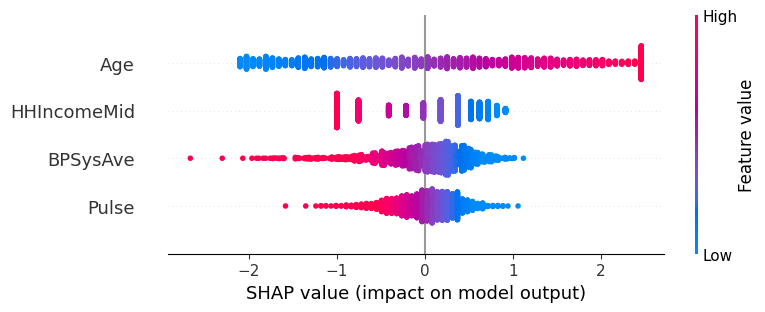

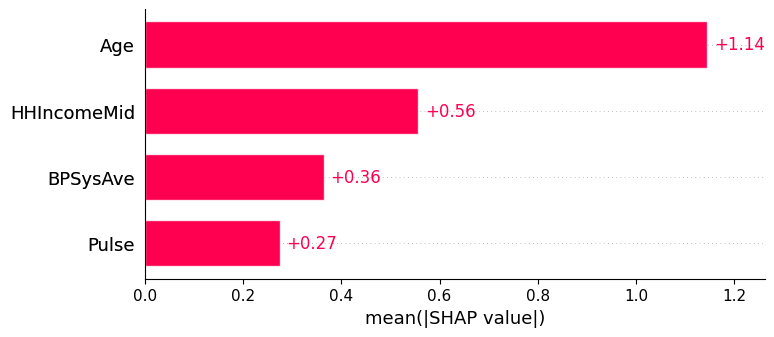

In [87]:
masker = shap.maskers.Independent(X_train.drop('BMI', axis=1))
explainer = shap.Explainer(logreg, masker)
shap_values = explainer(X_test.drop('BMI', axis=1))
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

#### Observational - 4 features (BMI excluded)

Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 3480.62it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


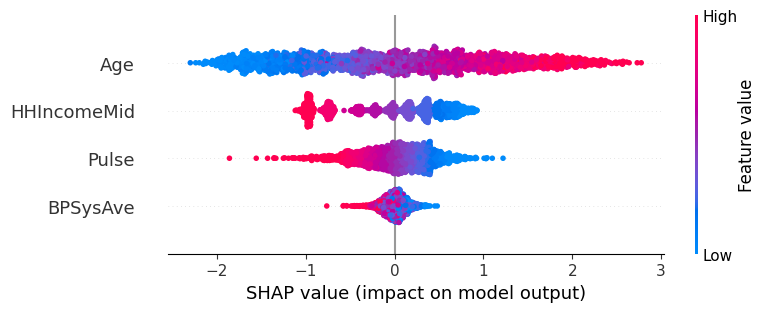

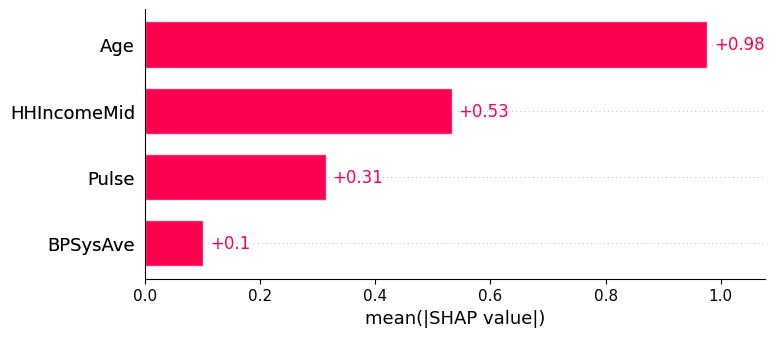

In [88]:
masker = shap.maskers.Impute(X_train.drop('BMI', axis=1))
explainer = shap.Explainer(logreg, masker, algorithm='linear')
shap_values = explainer(X_test.drop('BMI', axis=1))
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

#### Observational - 5 features

In [89]:
logreg = LogisticRegression(max_iter=100000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8928


Estimating transforms: 100%|██████████| 1000/1000 [00:00<00:00, 2844.74it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


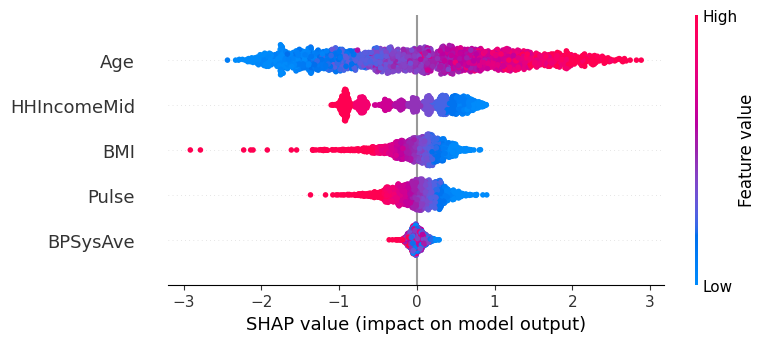

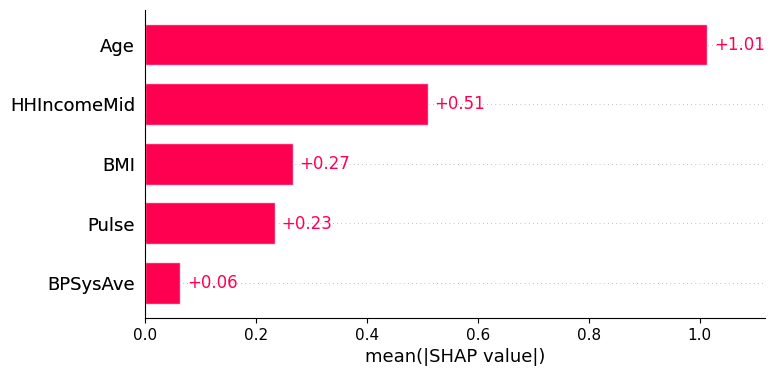

In [90]:
masker = shap.maskers.Impute(X_train)
explainer = shap.Explainer(logreg, masker, algorithm='linear')
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

### Lending club (4.1. True to the Model)

In [91]:
lc=pd.read_csv('data/lendingclub/loans_2007.csv', low_memory=False)

lc.dropna(axis=0, inplace=True)
lc.drop_duplicates(inplace=True)
# drop 'last_fico_range_high'
lc.drop('last_fico_range_high', axis=1, inplace=True)
lc.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,1,860,27.65,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,15.27,59.83,0,30000.0,0,309,1.00,0.0,744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,15.96,84.33,10,12252.0,1,606,8.72,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000.0,13.49,339.31,10,49200.0,1,917,20.00,0.0,694.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5000.0,7.90,156.46,3,36000.0,1,852,11.20,0.0,734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [92]:
X = lc.drop('loan_status', axis=1)
y = lc['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

logreg = LogisticRegression(max_iter=100000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.8600


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


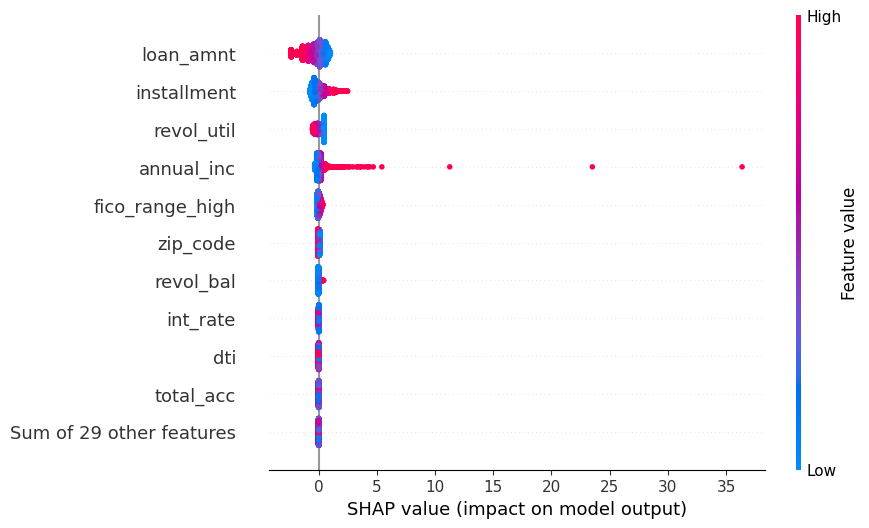

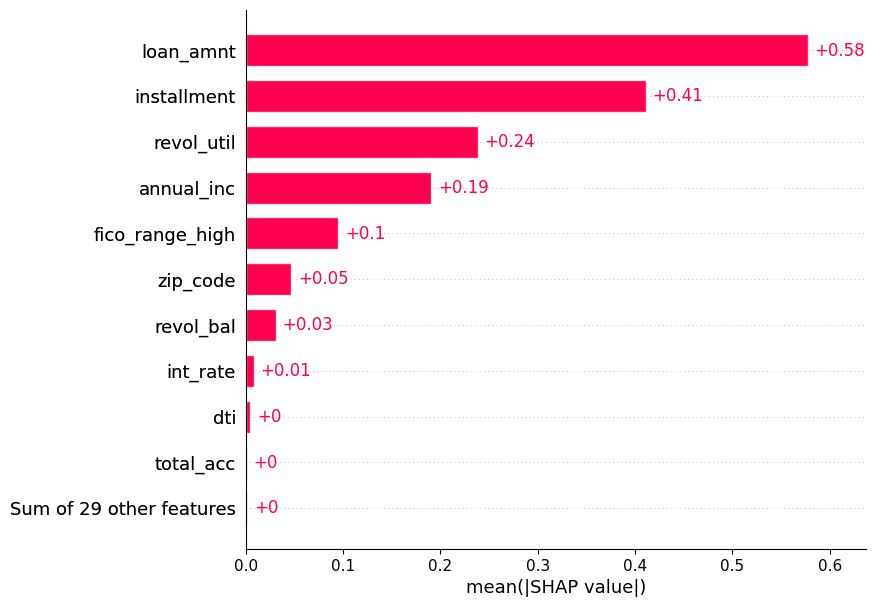

In [93]:
masker = shap.maskers.Independent(X_train)
explainer = shap.LinearExplainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [94]:
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_i=X_test.columns[ft_id]
top10_ft_i

Index(['loan_amnt', 'installment', 'revol_util', 'annual_inc',
       'fico_range_high', 'zip_code', 'revol_bal', 'int_rate', 'dti',
       'total_acc'],
      dtype='object')

Estimating transforms: 100%|██████████| 1000/1000 [00:03<00:00, 278.23it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


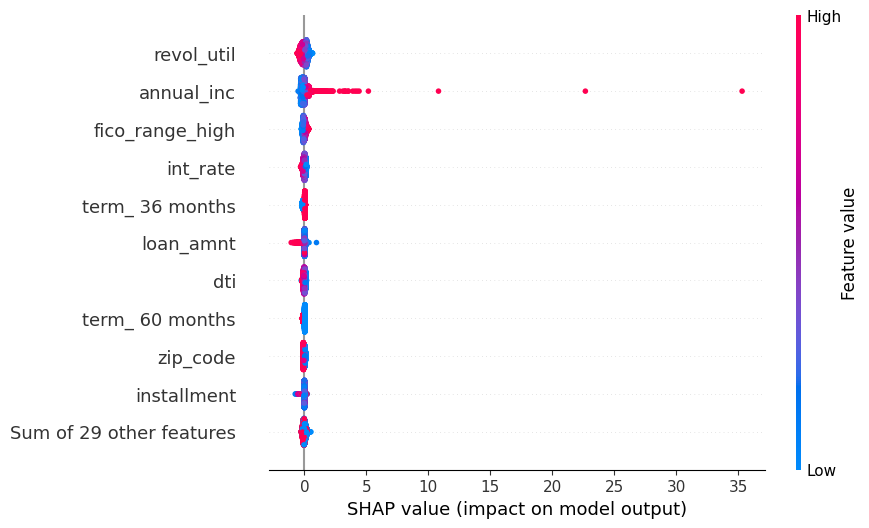

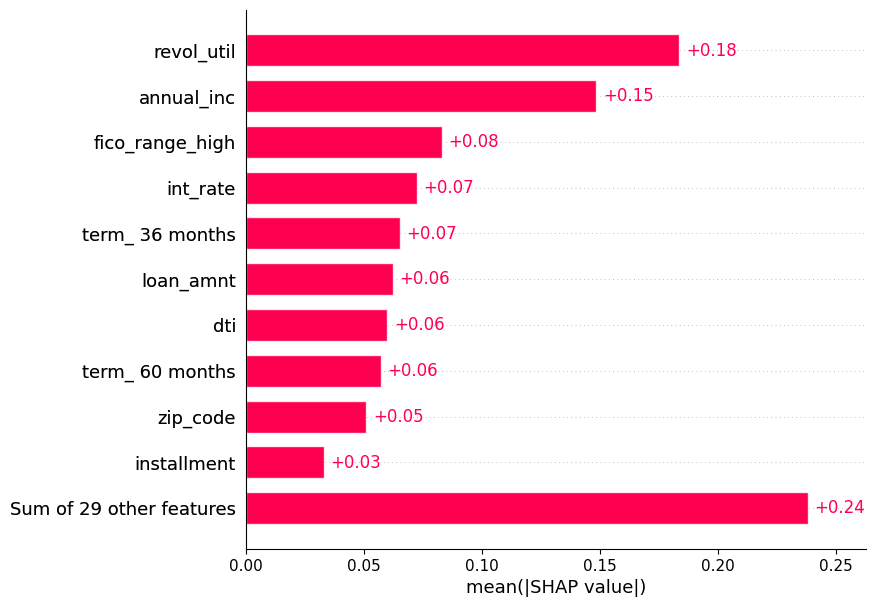

In [95]:
masker = shap.maskers.Impute(X_train)
explainer = shap.Explainer(logreg, masker, algorithm='linear')
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [96]:
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_c=X_test.columns[ft_id]
top10_ft_c

Index(['revol_util', 'annual_inc', 'fico_range_high', 'int_rate',
       'term_ 36 months', 'loan_amnt', 'dti', 'term_ 60 months', 'zip_code',
       'installment'],
      dtype='object')

Log odds difference

In [238]:
def logodds(X_test, logreg, top10_ft, diff=True):
    X_test_modified = X_test.copy()
    yp=logreg.predict(X_test)
    logodds_c = [np.log((len(yp[yp == 0])+1)/len(yp[yp == 1]+1))]
    # print(np.log(len(yp[yp == 1])/(len(yp[yp == 0])+1)))

    for feature in top10_ft:
        X_test_modified[feature] = X_test[feature].min()

        # print(logreg.predict_proba(X_test_modified)[0, 1] - logreg.predict_proba(X_test)[0, 1])
        # print(logreg.predict_proba(X_test_modified)[:, 1].mean())
        # print(logreg.predict_proba(X_test_modified)[:, 1].mean() - logreg.predict_proba(X_test)[:, 1].mean())

        # log odds ratio of the prediction
        y_pred = logreg.predict(X_test_modified)
        notdefault = y_pred[y_pred == 1]
        default = y_pred[y_pred == 0]

        # print(np.log(len(notdefault)/(len(default)+1)))
        logodds_c.append(np.log((len(default)+1)/(len(notdefault)+1)))

    if diff:
        logodds_diff = []
        for i in range(len(logodds_c)):
            logodds_diff.append(logodds_c[i] - logodds_c[i-1])

        logodds_diff[0] = 0
        logodds_diff

        return logodds, logodds_diff

    else:
        return logodds

In [224]:
logodds_c, logodds_diff_c = logodds(X_train, logreg, top10_ft_c)
logodds_i, logodds_diff_i = logodds(X_train, logreg, top10_ft_i)

### Preprocess

In [338]:
lclub=pd.read_csv('data/lendingclub.csv', low_memory=False)

In [339]:
# drop id
lclub.drop('id', axis=1, inplace=True)

In [340]:
# drop column with more than 1000 missing values
lclub.dropna(axis=1, thresh=int((1-(1000/lclub.shape[0]))*len(lclub)), inplace=True)

In [341]:
# every column that is categorical

lclub.select_dtypes(include=['object']).columns

Index(['issue_d', 'grade', 'sub_grade', 'addr_state', 'grade.1', 'purpose',
       'term', 'zip_code'],
      dtype='object')

In [342]:
# drop grades, addr_state
lclub.drop(['grade', 'sub_grade', 'grade.1', 'addr_state'], axis=1, inplace=True)

In [343]:
lclub.issue_d = pd.to_datetime(lclub.issue_d)

# lclub['issue_d_year'] = lclub.issue_d.dt.year # same year
lclub['issue_d_month'] = lclub.issue_d.dt.month

lclub.drop(['issue_d'], axis=1, inplace=True)

lclub.select_dtypes(include=['object']).columns

Index(['purpose', 'term', 'zip_code'], dtype='object')

In [344]:
# fill nan with mean
lclub.fillna(lclub.mean(numeric_only=True), inplace=True)

In [345]:
# remove months
lclub.term = lclub.term.str.extract('(\d+)').astype(int)

In [346]:
lclub.select_dtypes(include=['object']).columns

Index(['purpose', 'zip_code'], dtype='object')

In [347]:
# drop zip_code
lclub.drop(['zip_code'], axis=1, inplace=True)

In [348]:
# dummy variables
lclub = pd.get_dummies(lclub, columns=['purpose'], drop_first=True)

#### Calculate log odds/log odds difference after modifying the feature

In [349]:
# train test split
X = lclub.drop('loan_status', axis=1)
y = lclub['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

logreg = LogisticRegression(max_iter=100000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('- Accuracy of logistic regression classifier on test set: {:.4f}'\
    .format(accuracy_score(y_test, y_pred)))

- Accuracy of logistic regression classifier on test set: 0.7351


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


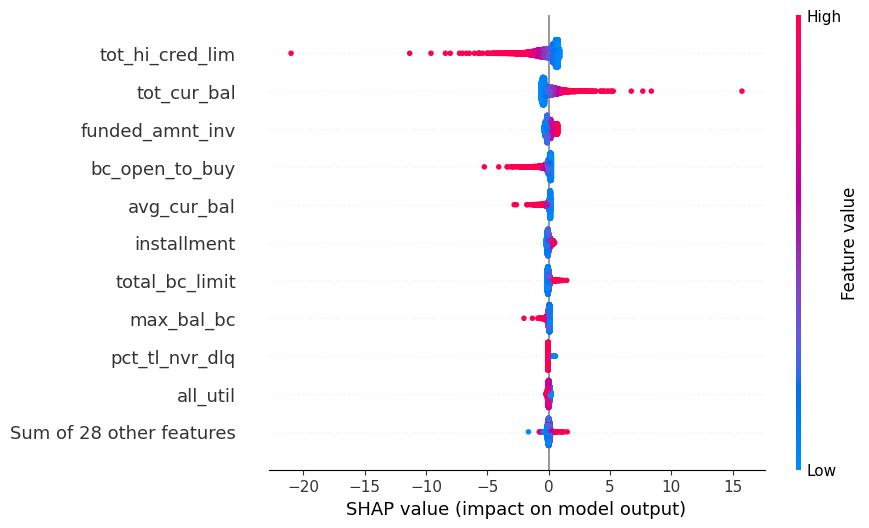

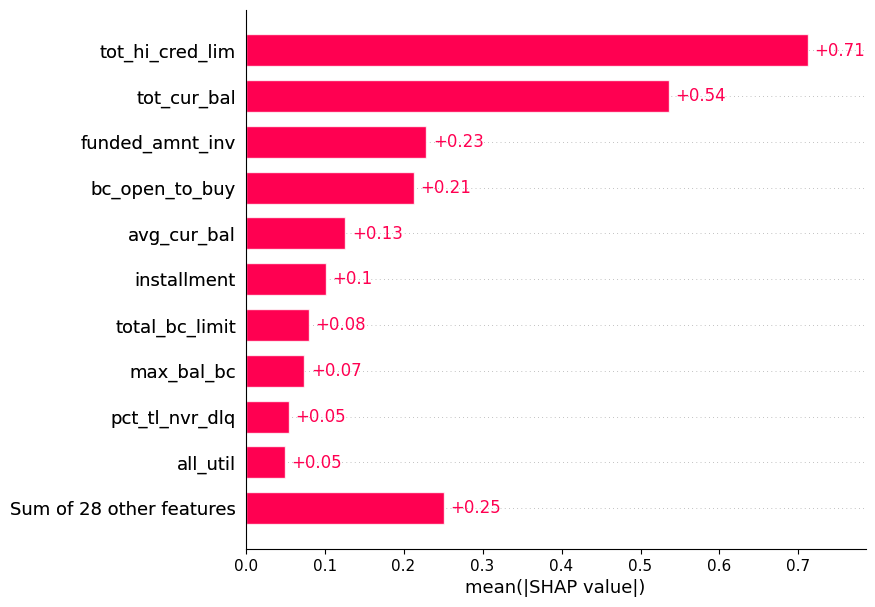

In [350]:
# shapley
masker = shap.maskers.Independent(X_train)
explainer = shap.LinearExplainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [351]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_i=X_test.columns[ft_id]
top10_ft_i

Index(['tot_hi_cred_lim', 'tot_cur_bal', 'funded_amnt_inv', 'bc_open_to_buy',
       'avg_cur_bal', 'installment', 'total_bc_limit', 'max_bal_bc',
       'pct_tl_nvr_dlq', 'all_util'],
      dtype='object')

Estimating transforms: 100%|██████████| 1000/1000 [00:03<00:00, 312.66it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


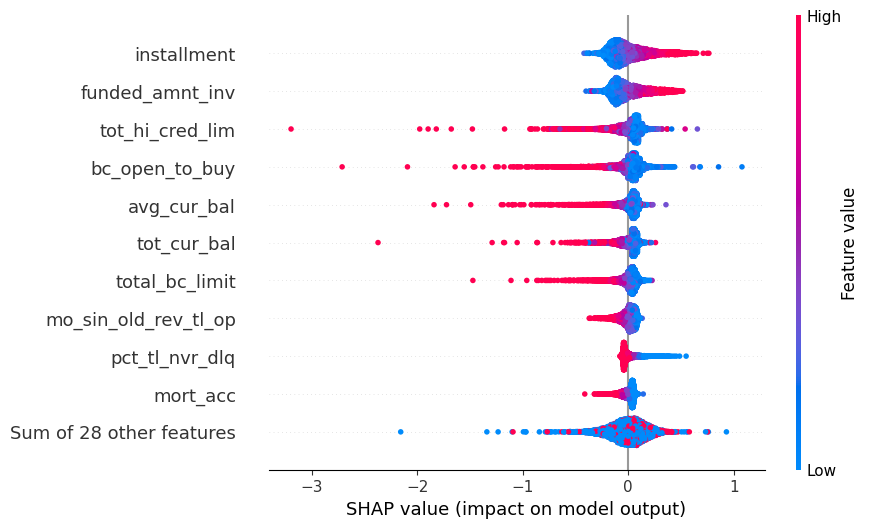

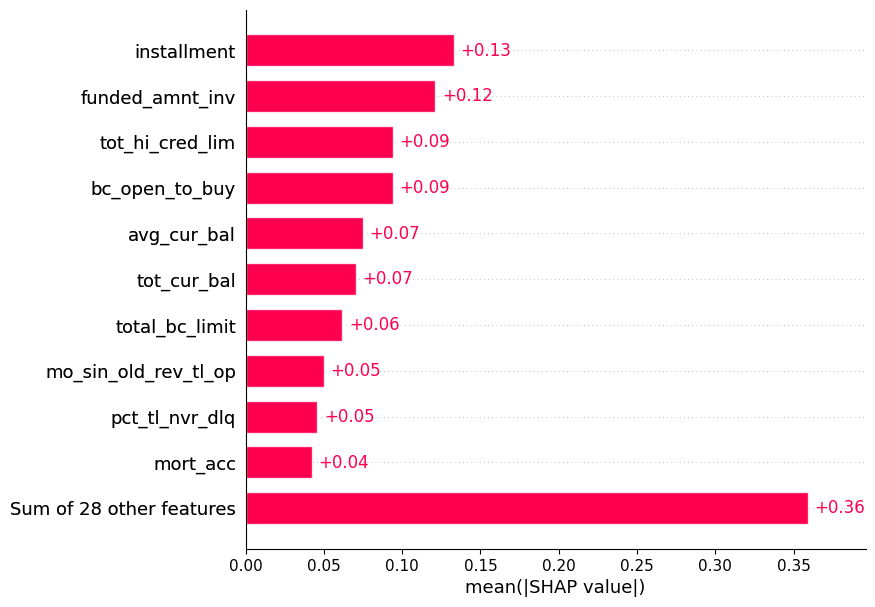

In [352]:
# observational
masker = shap.maskers.Impute(X_train)
explainer = shap.LinearExplainer(logreg, masker)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=11)

In [353]:
# top 10 features
ft_id=np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:10]
top10_ft_c=X_test.columns[ft_id]
top10_ft_c

Index(['installment', 'funded_amnt_inv', 'tot_hi_cred_lim', 'bc_open_to_buy',
       'avg_cur_bal', 'tot_cur_bal', 'total_bc_limit', 'mo_sin_old_rev_tl_op',
       'pct_tl_nvr_dlq', 'mort_acc'],
      dtype='object')

In [ ]:
ft_i_dict = [0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
ft_c_dict = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [357]:
ft_i_dict=dict(zip(top10_ft_i, ft_i_dict))
ft_c_dict=dict(zip(top10_ft_c, ft_c_dict))

In [424]:
def logodds_default(X_test, logreg, top10_ft_dict, diff=True):
    X_test_modified = X_test.copy()
    yp=logreg.predict(X_test)
    logodds_list = [np.log((len(yp[yp == 0])+1)/len(yp[yp == 1]+1))]

    for feature in top10_ft_dict.keys():
        if top10_ft_dict[feature] == 0:
            X_test_modified[feature] = X_test[feature].min()
        else:
            X_test_modified[feature] = X_test[feature].max()
        
        y_pred = logreg.predict(X_test_modified)
        notdefault = y_pred[y_pred == 1]
        default = y_pred[y_pred == 0]

        print(f'0/1: {len(notdefault)} / {len(default)}')

        logodds_list.append(np.log((len(default)+1)/(len(notdefault)+1)))

    print('-----------------')
    
    if diff:
        logodds_diff = []
        for i in range(len(logodds_list)):
            logodds_diff.append(logodds_list[i] - logodds_list[i-1])

        logodds_diff[0] = 0
        logodds_diff

        return logodds_list, logodds_diff

    else:
        return logodds_list

In [425]:
logodds_c, logodds_diff_c = logodds_default(X_test, logreg, ft_c_dict)
logodds_i, logodds_diff_i = logodds_default(X_test, logreg, ft_i_dict)

0/1: 396 / 5958
0/1: 3775 / 2579
0/1: 6250 / 104
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6348 / 6
0/1: 6341 / 13
0/1: 6347 / 7
0/1: 6352 / 2
0/1: 6352 / 2
-----------------
0/1: 2100 / 4254
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
0/1: 6354 / 0
-----------------


Text(0.5, 1.0, 'Change in log odds with respect to number of features changed')

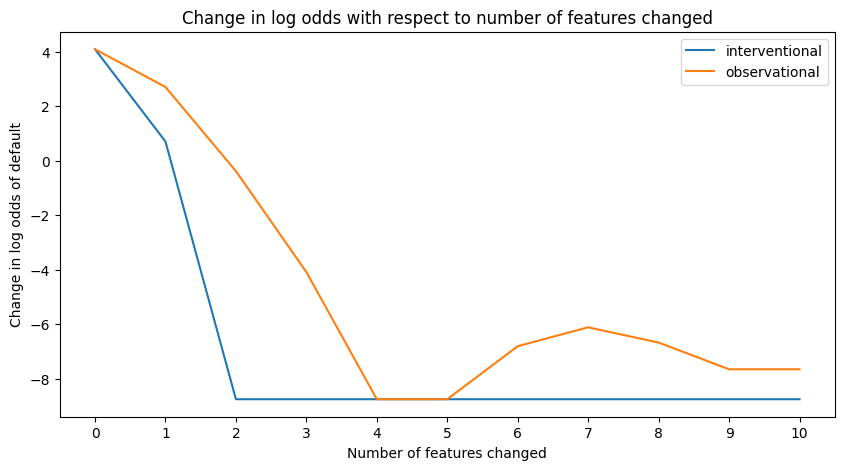

In [430]:
# logodds
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in log odds with respect to number of features changed')

Text(0.5, 1.0, 'Change in delta log odds with respect to number of features changed')

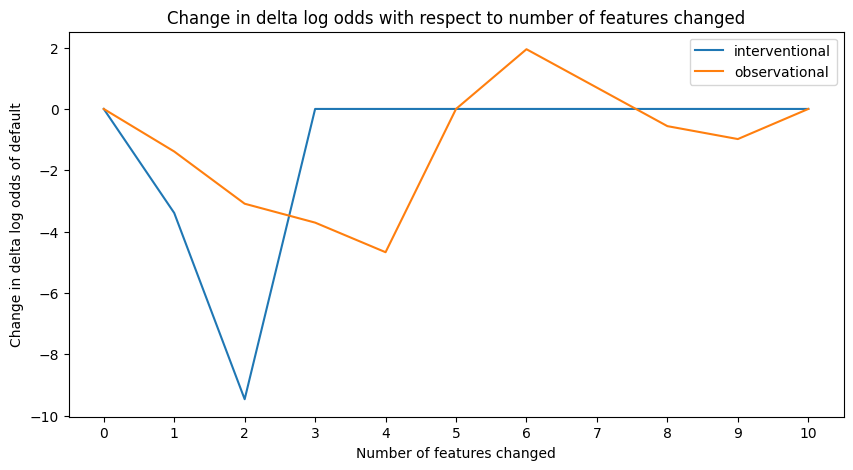

In [431]:
# delta logodds
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 11), logodds_diff_i, label='interventional')
plt.plot(np.arange(0, 11), logodds_diff_c, label='observational')
plt.xlabel('Number of features changed')
plt.ylabel('Change in delta log odds of default')
plt.legend()
plt.xticks(np.arange(0, 11))
plt.title('Change in delta log odds with respect to number of features changed')